# Emission model basics

Here we give an overview of the basic functionality of an ``EmissionModel``. Elsewhere we cover [what models are available](premade_models/premade_models.rst), [how to modify a model](modify_models.ipynb), [making your own custom models](custom_models.ipynb), and [combining_models from different components](combined_models.ipynb).

To use an ``EmissionModel`` model we simply instantiate it with the required arguments.
However, which arguments are required depends on the exact operation. 

## Operations 

### Extraction
For *extraction* operations you need:

- A grid to extract from (``grid``).
- A key to extract (``extract``). For lines, ``line_ids`` must be passed to ``get_lines``, this key is then the label given to the ``LineCollection``. 
- Optionally, an escape fraction to apply which defaults to 0.0 (``fesc`` or ``covering_fraction`` for AGN).

### Combination
For *combination* operations you need:

- A list of models which will be combined (i.e. added) to give the resultant emission (``combine``).

### Generation
For *generation* operations you need:

- A generator class (e.g. a [dust emission model](dust_emission.ipynb)) from which to generate spectra (``generator``). 

### Attenuation
For *attenuation* operations you need:

- The [dust curve](../attenuation/attenuation.rst) to apply (``dust_curve``).
- The model to apply the attenuation to (``apply_dust_to``).
- The optical depth to use with the dust curve (``tau_v``).

### Masking
Masking can be applied alongside any of these operations.
Any number of masks can be combined on the same operation.
Each mask is defined by:

- The attribute of the component to mask on (``mask_attr``).
- The threshold of the mask (``mask_thresh``).
- The operator to use when generating the mask, i.e. ``"<"``, ``">"``, ``"<="``, ``">="``, ``"=="``, or ``"!="`` (``mask_op``).


## Getting a model

For this demonstration we'll load the ``TotalEmission`` premade stellar emisison model.
We define a few key parameters when initialising the ``EmissionModel``, such as the dust curve and the $V$-band optical depth.

In [1]:
from unyt import Myr

from synthesizer.emission_models import TotalEmission
from synthesizer.emission_models.attenuation import PowerLaw
from synthesizer.grid import Grid

# Get the grid which we'll need for extraction
grid_dir = "../../../tests/test_grid"
grid_name = "test_grid"
grid = Grid(grid_name, grid_dir=grid_dir)

total = TotalEmission(grid=grid, dust_curve=PowerLaw(slope=-1), tau_v=0.67)

> When using more complex [premade models](premade_models/premade_models.rst), with a deeper "tree", more parameters will be required to populate their "child" models deeper in the tree.
> This tree terminology will become clear later -- don't worry about the specifics here if you are just starting with synthesizer ``EmissionModels``.

In addition to the arguments specfic to each type of model, any model can be passed arguments to define a mask:
- ``mask_attr``, the emitter attribute to define a mask with
- ``mask_op``, the operator to use in the mask
- ``mask_thresh``, the threshold for the mask

In the example below we apply a mask to the stellar ages, so that only emission from stars less than 10 Myr old are returned.

In [2]:
masked_total = TotalEmission(
    grid=grid,
    label="young_total",
    dust_curve=PowerLaw(slope=-1),
    tau_v=0.67,
    mask_attr="ages",
    mask_op="<",
    mask_thresh=10 * Myr,
)

> In the above case we used a global mask on the ``TotalEmission`` model, so that every child model in the tree has also been masked.
> In most (but certainly not all) cases you'll only want specific models masked. > This can either be done by [constructing your own models](custom_models.ipynb) or [modifying existing ones](modify_models.ipynb). 

## Printing a summary of an ``EmissionModel``

If we want to see a summary of all the models contained within an instance of an ``EmissionModel`` we simply print the model.

In [3]:
print(masked_total)

|====================================== EmissionModel: young_total ======================================|
|--------------------------------------------------------------------------------------------------------|
|  NEBULAR (stellar)                                                                                     |
|--------------------------------------------------------------------------------------------------------|
|Extraction model:                                                                                       |
|  Grid: test_grid                                                                                       |
|  Extract key: nebular                                                                                  |
|  Escape fraction: 0.0                                                                                  |
|  Save emission: True                                                                                   |
|  Masks:                            

This returns a text block describing each model, including its label (in all caps), its emitter (in brackets after the label), and the operation the model performs, followed by the parameters defining the operation.

## Plotting an ``EmissionModel``

For a more detailed view of how models relate to each other we can visualise the tree itself:

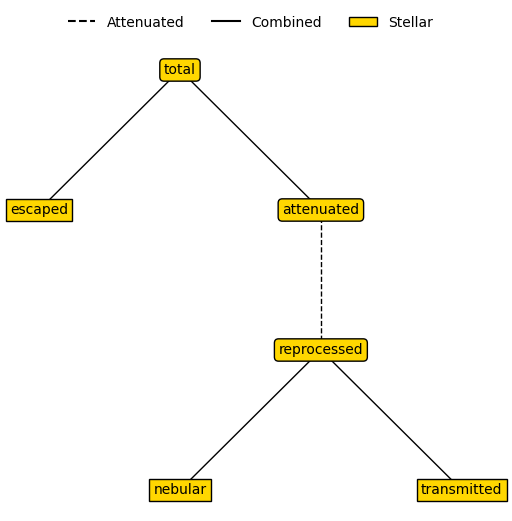

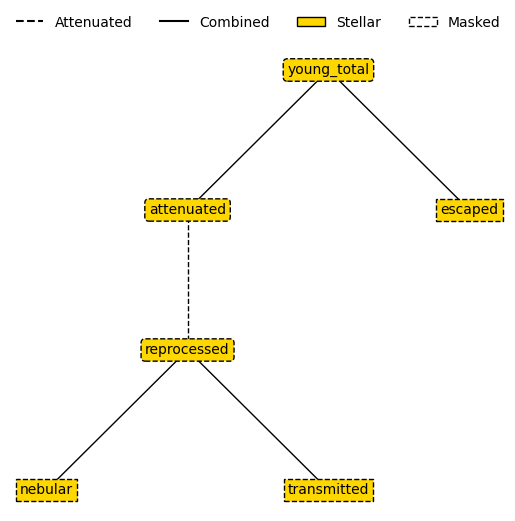

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [4]:
total.plot_emission_tree()
masked_total.plot_emission_tree()

In the tree we can see each individual spectra generated by the model, and how they relate:

- Solid lines denote combinations of spectra. 
- Dashed lines denote an attenuation of the child spectra to produce the parent. 
- Dotted lines denote a relationship between the parent generator and it's child spectra used to scale the generated spectra (not required for all generators). 
- Blue boxes have no mask applied. 
- Green boxes have a mask applied to them (which we only have for the masked model we made). 
- Square boxes are an extraction operation. 
- Boxes with rounded corners are generation, dust attenuation or combination operations. 

You'll notice the extraction operations are always leaves in the tree.

## Extracting models

An emission model can be treated like a dictionary -- if we want to get a model from somewhere in the tree, we simply index with the model label.

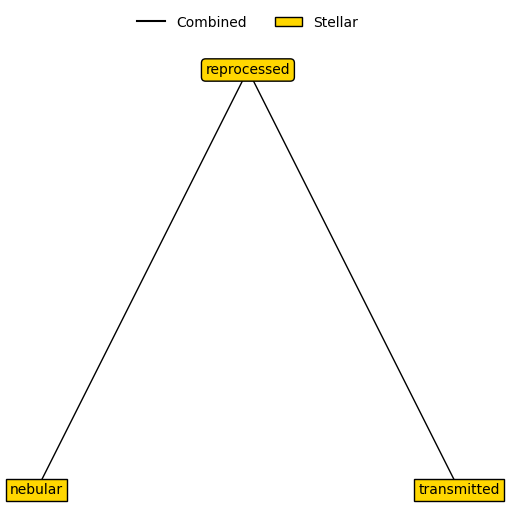

(<Figure size 600x600 with 1 Axes>, <Axes: >)

In [5]:
sub_model = total["reprocessed"]
sub_model.plot_emission_tree()